# Your NutritionBro:  Nutrition evaluation System

### 1. Set up environment  
Import useful package and modules

In [48]:
# torch related
import torch
import torch.nn as nn
from torchvision import transforms

# basic libraries
import numpy as np
import os, pickle, time, random
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from collections import Counter

# for recognize ingredients in images
from suply.args import get_parser
from nutribro_model.model import get_model

# for read nutritient API
from urllib.request import Request, urlopen
import pandas as pd
import warnings, re

Set ```root_dir``` to the path including vocabularies and model file

In [49]:
data_dir = './'

Check if GPU available

In [50]:
use_gpu = True
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

### 2. Load vocabulary and model

load and preprocess vacabulary

In [51]:
ingrs_vocab = pickle.load(open('vocab_ingrs.pkl', 'rb'))
ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
pickle.dump(ingrs_vocab, open('ingr_vocab.pkl', 'wb'))

ingrs_vocab = pickle.load(open('ingr_vocab.pkl','rb'))
ingr_vocab_size = len(ingrs_vocab)

In [52]:
print (ingr_vocab_size)

978


In [53]:
t = time.time()
import sys; sys.argv=['']; del sys
args = get_parser()
model = get_model(args, ingr_vocab_size)

# Load the trained model parameters
model_path = './result/find_ingredient/ingredient_QIXI/checkpoints/modelbest.ckpt'
model.load_state_dict(torch.load(model_path, map_location=map_loc))
model.to(device)
model.eval()

print ('loaded model')
print ("Elapsed time:", time.time() -t)

KeyError: 'resnet50'

### Load and Preprocess test images

Define preprocess for input image

In [45]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406), 
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

Get test image

./test_img\sushi.jpg


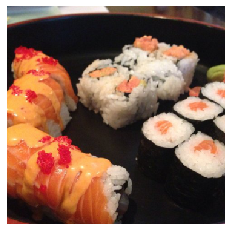

./test_img\cherry_cake.jpg


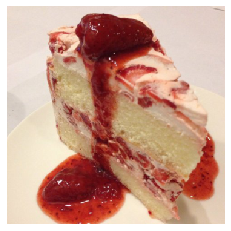

In [54]:
image_folder = os.path.join(data_dir, 'test_img')
test_imgs = os.listdir(image_folder)
random.shuffle(test_imgs)
to_test = []
for img_file in test_imgs:
    
    if use_urls:
        response = requests.get(img_file)
        image = Image.open(BytesIO(response.content))
    else:
        image_path = os.path.join(image_folder, img_file)
        print(image_path)
        if image_path[-3:] != 'jpg':
            continue
        image = Image.open(image_path).convert('RGB')
    
    transf_list = []
    transf_list.append(transforms.Resize(384))
    transf_list.append(transforms.CenterCrop(360))
    transform = transforms.Compose(transf_list)
    
    image_transf = transform(image)
    image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
    to_test.append(image_tensor)
    plt.imshow(image_transf)
    plt.axis('off')
    plt.show()
    plt.close()

### 3. For fetch nutritient

In [15]:
# See https://fdc.nal.usda.gov/api-guide.html for API documentation

import requests

def fdc_search(apikey, term, url = 'https://api.nal.usda.gov/fdc/v1/search'): 
    """
    Search Food Central Database, using apikey and string "term" as search criterion.
    Returns a pd.DataFrame of results.
    """
    parms = (('format', 'json'),('generalSearchInput', term),('api_key', apikey))
    r = requests.get(url, params = parms)

    if 'foods' in r.json():
        l = r.json()['foods']
    else: 
        return []

    return pd.DataFrame(l)

def ingre_2_nutr(ingredients):
    nutritient_set = set()
    for food in ingredients:
        food_web = fdc_search('c2Xleu5EaNWTfYARE7U8J1mDiClDSb01wI4bMBeC',food)
        if len(food_web) == 0:
            print("Sorry didnt get nutritrient for {}".format(food))
            continue
        nutri_info = food_web["foodNutrients"][0:1].tolist()[0]
        for item in nutri_info:
            if item['value'] >0.000001 and bool(re.search('[a-z]', item['nutrientName'])):# and item['nutrientName'].isalpha():
                #print(food, item['nutrientName'])
                nutritient_set.add(item['nutrientName'])
    return nutritient_set
        

### 4. Predict with model

In [47]:
def generate(image_tensor):
        with torch.no_grad():
            outputs = model.sample(image_tensor, greedy=True, 
                                   temperature=1.0, beam=-1, true_ingrs=None)
            
        ingr_ids = outputs['ingr_ids'].cpu().numpy()
        gen_ingrs = []
        for ingr_idx in ingr_ids[0]:
            ingr_name = ingrs_vocab[ingr_idx]
            if ingr_name == '<pad>':
                break
            gen_ingrs.append(ingr_name)
 
        BOLD = '\033[1m'
        END = '\033[0m'

        print (BOLD + '\nIngredients:'+ END)
        print (', '.join(gen_ingrs))
        print ('='*120)
        return gen_ingrs
        
for image_tensor in to_test:
    ingredient_list = generate(image_tensor)
    print(ingre_2_nutr(ingredient_list))

NameError: name 'model' is not defined